In [1]:
import pandas as pd
df = pd.read_csv('cleaned_dataset.csv')
text_column = "dummy_text"

In [2]:
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import community.community_louvain as community_louvain

# Download stopwords if not already available
nltk.download("stopwords")

# Define Stopwords & Additional Filters
custom_stopwords = set([
    "html", "https", "com", "click", "expand", "www", "http", "href", "class", 
    "span", "div", "one", "would", "also", "like", "people", "even", "just", 
    "could", "many", "much", "said", "trump", "us", "time", "know", "think", 
    "see", "good", "wikipedia", "view", "attachment", "wiki", "totaldisclosure", 
    "expand click",  "highlightreply", "bbcode", 
    "container", "stormfront org" ,"en org", "stormfront org forum", "channel httpstme","join sgtnewsnetwork twitter" ,"co uk"
])
stop_words = set(stopwords.words("english")).union(custom_stopwords)

# Text Cleaning Function with Stopword Removal
def clean_text(text):
    if isinstance(text, str):
        text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        text = re.sub(r"\b\d+\b", "", text)  # Remove numbers
        text = re.sub(r"\b[a-zA-Z]\b", "", text)  # Remove single characters
        text = re.sub(r"\s+\b[a-zA-Z]\b\s+", " ", text)  # Double-check isolated letters
        text = re.sub(r"\b(?:span|class|div|href|onclick|highlightreply|bbcode|container)\b", "", text)  # Remove HTML artifacts
        text = re.sub(r"\b[a-zA-Z0-9]{15,}\b", "", text)  # Remove long gibberish words
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        
        # Remove stopwords
        text = " ".join([word for word in text.split() if word not in stop_words])

        return text
    return ""


# Apply Text Cleaning
df[text_column] = df[text_column].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /users/PLS0150/arnobrahee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from networkx.algorithms.community import louvain_communities
from pyvis.network import Network

# ------------------ Step 1: Setup ------------------
print("🔍 Starting topic co-occurrence graph generation...")
text_column = "dummy_text"
df_sample = df.copy()

# ------------------ Step 2: Identify Binary Columns ------------------
print("🧾 Identifying binary columns...")
binary_columns = [col for col in df.columns if col != text_column and df[col].nunique() == 2]
print(f"✅ Found {len(binary_columns)} binary columns.")

# ------------------ Step 3: Initialize BERTopic ------------------
print("🧠 Initializing BERTopic model...")
umap_model = UMAP(n_components=5, n_neighbors=15, metric="cosine", random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=10,
    nr_topics=50,
    verbose=False,
)

# ------------------ Step 4: Fit Topics for y=1 Only ------------------
print("📊 Fitting topics for each binary label (y=1)...")
topic_label_map = {}
topic_keywords = {}

for col in binary_columns:
    print(f"➡️ Processing label column: {col}")
    docs = df_sample[df_sample[col] == 1][text_column].astype(str).tolist()
    if len(docs) < 5:
        print(f"   ❌ Skipping {col} (too few documents: {len(docs)})")
        continue

    topics, _ = topic_model.fit_transform(docs)
    print(f"   ✅ Fitted {len(set(topics)) - (1 if -1 in topics else 0)} topics for {col}")

    for topic_id in set(topics):
        if topic_id == -1:
            continue
        topic_label_map.setdefault(topic_id, set()).add(col)
        if topic_id not in topic_keywords:
            topic_keywords[topic_id] = topic_model.get_topic(topic_id)

print(f"🧾 Total topics found: {len(topic_label_map)}")

# ------------------ Step 5: Build Co-occurrence Graph ------------------
print("🔗 Building topic co-occurrence graph...")
G = nx.Graph()

# Add nodes with keywords
for topic_id, words in topic_keywords.items():
    top_words = " ".join([w for w, _ in words[:3]])
    G.add_node(topic_id, label=top_words)

# Add edges for shared labels (min 2 to reduce clutter)
for t1, t2 in combinations(topic_label_map.keys(), 2):
    shared_labels = topic_label_map[t1].intersection(topic_label_map[t2])
    if len(shared_labels) >= 2:
        G.add_edge(t1, t2, weight=len(shared_labels))

print(f"📈 Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# ------------------ Step 6: Community Detection ------------------
print("🧩 Applying Louvain community clustering...")
communities = louvain_communities(G, seed=42)
partition = {}
for group_id, community_nodes in enumerate(communities):
    for node in community_nodes:
        partition[node] = group_id

# ------------------ Step 7: PyVis Interactive Graph ------------------
print("🌐 Building interactive network (PyVis)...")
net = Network(height="750px", width="90%", notebook=False)
net.barnes_hut()

for node in G.nodes():
    label = G.nodes[node]["label"]
    size = 15 + 5 * len(topic_label_map[node])
    group = partition[node]
    net.add_node(node, label=label, size=size, group=group)

for source, target, data in G.edges(data=True):
    net.add_edge(source, target, value=data["weight"])

net.save_graph("topic_cooccurrence_interactive.html")
print("✅ PyVis interactive graph saved as 'topic_cooccurrence_interactive.html'")




🔍 Starting topic co-occurrence graph generation...
🧾 Identifying binary columns...
✅ Found 61 binary columns.
🧠 Initializing BERTopic model...
📊 Fitting topics for each binary label (y=1)...
➡️ Processing label column: st_conspiracy
   ✅ Fitted 18 topics for st_conspiracy
➡️ Processing label column: st_healthmisinfo
   ✅ Fitted 9 topics for st_healthmisinfo
➡️ Processing label column: st_left
   ✅ Fitted 12 topics for st_left
➡️ Processing label column: st_mano
   ✅ Fitted 49 topics for st_mano
➡️ Processing label column: st_paleo
   ✅ Fitted 11 topics for st_paleo
➡️ Processing label column: st_patriot
   ✅ Fitted 12 topics for st_patriot
➡️ Processing label column: st_qanon
   ✅ Fitted 5 topics for st_qanon
➡️ Processing label column: st_ernews
   ✅ Fitted 2 topics for st_ernews
➡️ Processing label column: st_altright
   ✅ Fitted 2 topics for st_altright
➡️ Processing label column: st_religion
   ✅ Fitted 23 topics for st_religion
➡️ Processing label column: sts_christian
   ✅ Fitted

Improved graph

🧹 Re-plotting with community color clustering...


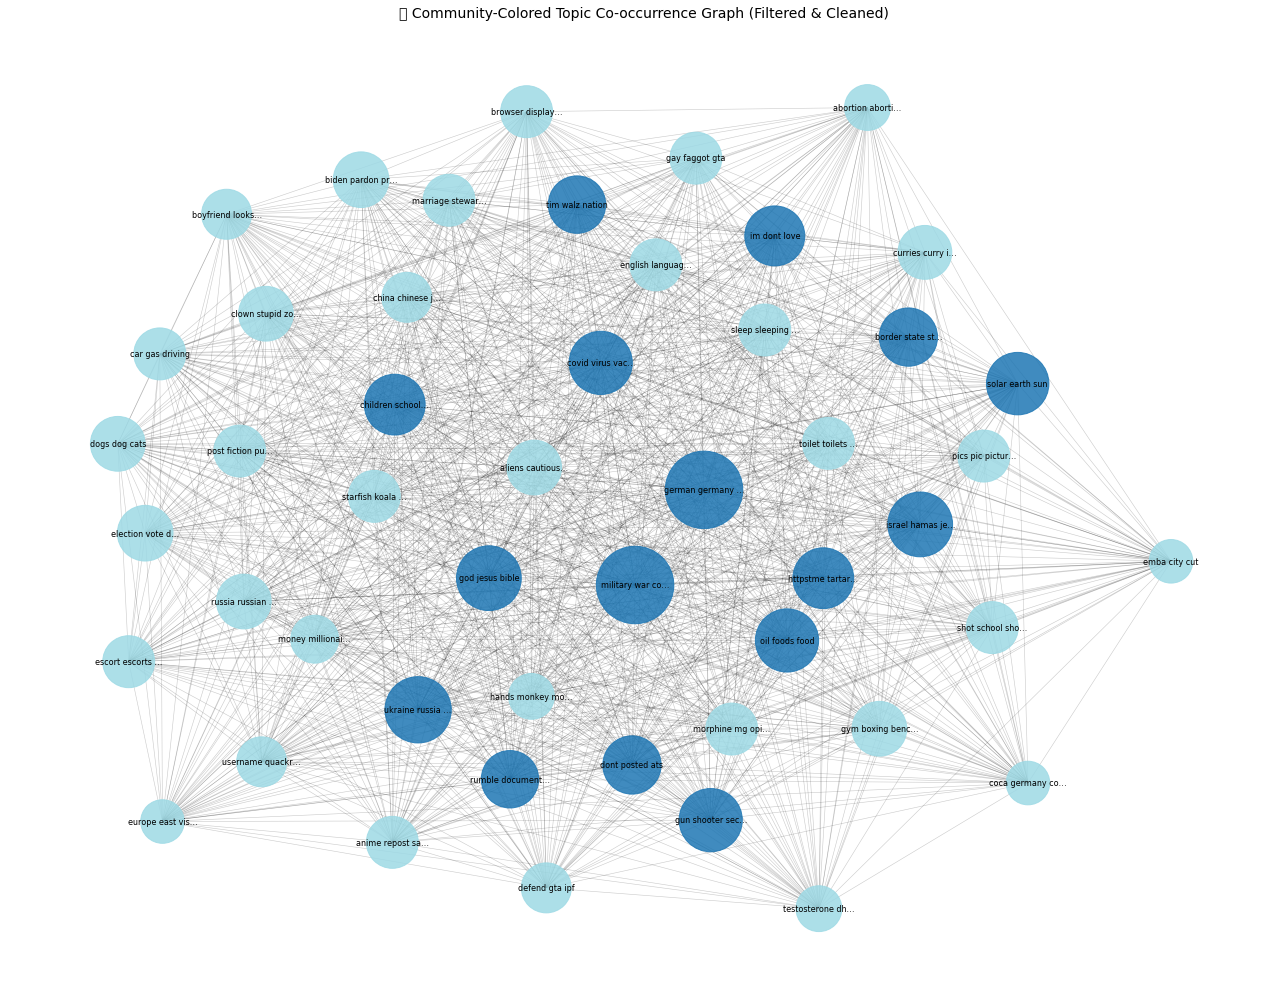

✅ Saved community-clustered graph to 'topic_cooccurrence_graph_community.png'


In [8]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.cm as cm
import numpy as np

# ------------------ Clean + Community-Clustered Plot ------------------
print("🧹 Re-plotting with community color clustering...")

# 1. Recompute layout with spacing
pos = nx.spring_layout(G, seed=42, k=0.35)

# 2. Filter edges with weight >= 3
edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] >= 3]
G_filtered = G.edge_subgraph(edges_to_keep).copy()

# 3. Louvain community detection
communities = louvain_communities(G_filtered, seed=42)
partition = {}
for group_id, nodes in enumerate(communities):
    for node in nodes:
        partition[node] = group_id

# 4. Assign colors to communities
num_communities = len(communities)
color_map = cm.get_cmap("tab20", num_communities)
node_colors = [color_map(partition[n]) for n in G_filtered.nodes()]

# 5. Resize nodes based on label count
node_sizes = [300 + 100 * len(topic_label_map[n]) for n in G_filtered.nodes()]

# 6. Prepare labels (truncate if too long)
labels = {n: G.nodes[n]["label"][:15] + "…" if len(G.nodes[n]["label"]) > 15 else G.nodes[n]["label"]
          for n in G_filtered.nodes()}

# 7. Plot
plt.figure(figsize=(18, 14))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
nx.draw_networkx_edges(G_filtered, pos, alpha=0.2, width=0.6)
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8)
plt.title("🎨 Community-Colored Topic Co-occurrence Graph (Filtered & Cleaned)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig("topic_cooccurrence_graph_community.png", dpi=300)
plt.show()

print("✅ Saved community-clustered graph to 'topic_cooccurrence_graph_community.png'")


Label to topic

In [3]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

# ------------------ Setup ------------------
text_column = "dummy_text"
df_sample = df.copy()

# Identify binary y columns
binary_columns = [col for col in df.columns if col != text_column and df[col].nunique() == 2]

# Initialize BERTopic
umap_model = UMAP(n_components=5, n_neighbors=15, metric="cosine", random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=10,
    nr_topics=50,
    verbose=False,
)

# ------------------ Build Label-to-Topic Matrix ------------------
topic_label_counts = {}
topic_keywords_map = {}

for col in binary_columns:
    docs = df_sample[df_sample[col] == 1][text_column].astype(str).tolist()
    if len(docs) < 5:
        continue
    topics, _ = topic_model.fit_transform(docs)
    
    for topic in topics:
        if topic == -1:
            continue
        topic_label_counts.setdefault(topic, {}).setdefault(col, 0)
        topic_label_counts[topic][col] += 1

    # Save keywords for topics
    for topic_id in set(topics):
        if topic_id != -1 and topic_id not in topic_keywords_map:
            words = topic_model.get_topic(topic_id)
            keyword_str = ", ".join([w for w, _ in words[:3]])  # top 3 keywords
            topic_keywords_map[topic_id] = keyword_str

# ------------------ Create Final Table ------------------
# Convert to DataFrame
table_df = pd.DataFrame(topic_label_counts).fillna(0).astype(int).T

# Rename index with topic keywords
table_df.index = table_df.index.map(lambda tid: topic_keywords_map.get(tid, f"Topic {tid}"))
table_df.index.name = "Topic Keywords"

# Display table + Save
display(table_df)
table_df.to_csv("label_to_topic_table.csv")
print("✅ Saved heatmap table as 'label_to_topic_table.csv'")


/users/PLS0150/arnobrahee/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


,st_conspiracy,st_mano,st_religion,disorder_chaos_sub,disorder_chaos_sub_wq,disorder_crime_sub,disorder_crime_sub_wq,disorder_harm_sub,disorder_harm_sub_wq,disorder_militarism_sub,...,disorder_aggress_sub,disorder_aggress_sub_wq,disorder_evil_sub,disorder_evil_sub_wq,disorder_selfharm_sub,disorder_selfharm_sub_wq,toxic_antisem_sub,toxic_antisem_sub_wq,toxic_religvalues_sub,toxic_religvalues_sub_wq
Topic Keywords,,,,,,,,,,,,,,,,,,,,,
"biden, pardon, president",20,72,29,14,14,160,160,24,24,12,...,0,0,0,0,0,0,0,0,0,0
"israel, hamas, jews",133,221,844,11,11,20,20,36,36,49,...,0,0,0,0,0,0,0,0,0,0
"god, jesus, bible",217,236,12,44,44,14,14,19,19,25,...,0,0,0,0,0,0,0,0,0,0
"dont, posted, ats",94,79,118,44,44,13,13,196,196,25,...,0,0,0,0,0,0,0,0,0,0
"covid, virus, vaccines",64,149,137,15,15,22,22,33,33,11,...,0,0,0,0,0,0,0,0,0,0
"solar, earth, sun",127,148,73,32,32,38,38,28,28,89,...,0,0,0,0,0,0,0,0,0,0
"im, dont, love",102,91,41,34,34,39,39,33,33,17,...,0,0,0,0,0,0,0,0,0,0
"election, vote, democrats",73,71,44,170,170,49,49,16,16,11,...,0,0,0,0,0,0,0,0,0,0
"httpstme, tartaria, water",81,121,17,45,45,12,12,18,18,15,...,0,0,0,0,0,0,0,0,0,0


✅ Saved heatmap table as 'label_to_topic_table.csv'
